In [105]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from astropy.coordinates import SkyCoord
from astropy.io import fits
from gammapy.irf import load_irf_dict_from_file
from scipy.stats import chi2, poisson

**Adjust with the correct file paths**

In [106]:
blazar_coord = SkyCoord.from_name("Mrk 421")
data_folder = "../data/mrk_421/"
irf_file = "../data/irfs/Prod5-North-40deg-AverageAz-4LSTs09MSTs.180000s-v0.1.fits.gz"

In [107]:
blazar_l = blazar_coord.galactic.l.deg
blazar_b = blazar_coord.galactic.b.deg

hbus = []
for filename in os.listdir(data_folder):
    hbus.append(fits.open(data_folder + filename))

irf = load_irf_dict_from_file(irf_file)
aeff = irf["aeff"]
print(f"Pointings: {len(hbus)}")

Pointings: 118


**Data collecting and overview**

In [110]:
# Source - background cake angle
src_angle = 0.2
# Extended emission angle
ext_angle = 0.25

data = {
    "src_energy": np.array([]),
    "ext_src_energy": np.array([]),
    "src_sep": np.array([]),
    "bkg_energy": np.array([]),
    "ext_bkg_energy": np.array([]),
    "all_coords_l": np.array([]),
    "all_coords_b": np.array([]),
    "all_energies": np.array([]),
    "all_sep": np.array([]),
    "offsets": np.array([]),
    "t_tot": np.array([]),
}

for hbu in hbus:
    data_raw = hbu["EVENTS"].data

    coord = SkyCoord(
        ra=data_raw["RA"] * u.deg, dec=data_raw["DEC"] * u.deg, frame="icrs"
    )

    pointing_coord = SkyCoord(
        ra=hbu[1].header["RA_PNT"] * u.deg,
        dec=hbu[1].header["DEC_PNT"] * u.deg,
        frame="icrs",
    )

    bkg_center = SkyCoord(
        l=2 * pointing_coord.galactic.l - blazar_coord.galactic.l,
        b=2 * pointing_coord.galactic.b - blazar_coord.galactic.b,
        frame="galactic",
    )

    src_pos_mask = coord.separation(blazar_coord).degree < src_angle
    bkg_pos_mask = coord.separation(bkg_center).degree < src_angle
    ext_src_pos_mask = coord.separation(blazar_coord).degree > ext_angle
    ext_bkg_pos_mask = coord.separation(bkg_center).degree > ext_angle

    t = data_raw["TIME"]
    t = np.sort(t)
    t_tot = t[-1] - t[0]

    data["src_energy"] = np.concatenate(
        [data["src_energy"], data_raw["ENERGY_TRUE"][src_pos_mask]]
    )

    data["bkg_energy"] = np.concatenate(
        [data["bkg_energy"], data_raw["ENERGY_TRUE"][bkg_pos_mask]]
    )

    data["ext_src_energy"] = np.concatenate(
        [
            data["ext_src_energy"],
            data_raw["ENERGY_TRUE"][src_pos_mask * ext_src_pos_mask],
        ]
    )

    data["src_sep"] = np.concatenate(
        [data["src_sep"], coord[src_pos_mask].separation(blazar_coord).degree]
    )

    data["all_coords_l"] = np.concatenate([data["all_coords_l"], coord.galactic.l.deg])
    data["all_coords_b"] = np.concatenate([data["all_coords_b"], coord.galactic.b.deg])
    data["all_energies"] = np.concatenate([data["all_energies"], data_raw["ENERGY"]])
    data["all_sep"] = np.concatenate(
        [data["all_sep"], coord.separation(blazar_coord).degree]
    )
    data["offsets"] = np.concatenate(
        [data["offsets"], [pointing_coord.separation(blazar_coord).degree]]
    )
    data["t_tot"] = np.concatenate([data["t_tot"], [t_tot]])

print(f"Near source events: {len(data['src_energy'])}")
print(f"Background events: {len(data['bkg_energy'])}")
print(f"Total events: {len(data['all_energies'])}")
print(f"Exposure time = {np.sum(data["t_tot"])/60/60:.1f}h")

Near source events: 98567
Background events: 19121
Total events: 3335834
Exposure time = 16.2h


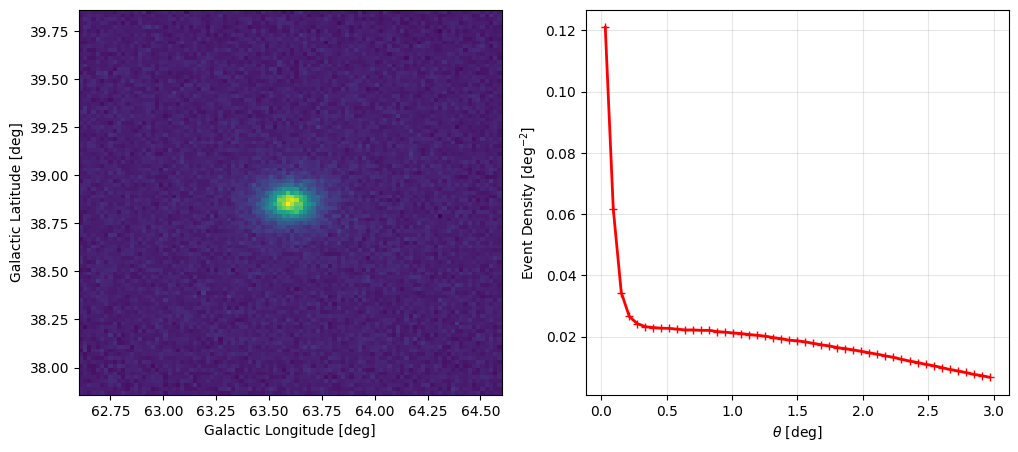

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Data overview
counts, xedges, yedges, im = ax1.hist2d(
    data["all_coords_l"],
    data["all_coords_b"],
    bins=100,
    range=[[blazar_l - 1, blazar_l + 1], [blazar_b - 1, blazar_b + 1]],
    cmap="viridis",
)

ax1.set_xlabel("Galactic Longitude [deg]")
ax1.set_ylabel("Galactic Latitude [deg]")
# ax1.set_title("Data overview")

# Radial distribution
radial_bins = np.linspace(0, 3, 50)
radial_counts, bin_edges = np.histogram(data["all_sep"], bins=radial_bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Normalize by area
areas = np.pi * (bin_edges[1:] ** 2 - bin_edges[:-1] ** 2)
density = radial_counts / areas
density = density / np.sum(density)
ax2.plot(bin_centers, density, marker="+", color="red", linewidth=2)
ax2.set_xlabel(r"$\theta$ [deg]")
ax2.set_ylabel(r"Event Density [deg$^{-2}$]")
# ax2.set_title("Radial Event Density Profile")
ax2.grid(True, alpha=0.3)
plt.show()

**Background removal and source SED approximation**

In [7]:
energy_bins = np.logspace(-1, 1, 20)
bin_edges = energy_bins
bin_centers = (energy_bins[:-1] + energy_bins[1:]) / 2

src_counts, _ = np.histogram(data["src_energy"], bins=energy_bins)
bkg_counts, _ = np.histogram(data["bkg_energy"], bins=energy_bins)
net_counts = src_counts - bkg_counts

# Considering a Poisson distribution.
src_errors = np.sqrt(src_counts)
bkg_errors = np.sqrt(bkg_counts)
net_errors = np.sqrt(src_counts + bkg_counts)

In [8]:
# Source SED approximation
blazar_offset = np.mean(data["offsets"])
dE = energy_bins[1:] - energy_bins[:-1]
exposure_time = np.sum(data["t_tot"])
effective_area = (
    aeff.evaluate(energy_true=bin_centers * u.TeV, offset=blazar_offset * u.deg)
    .to(u.cm**2)
    .value
)
sed_points = net_counts * (bin_centers**2) / (exposure_time * effective_area * dE)
sed_errors = net_errors * (bin_centers**2) / (exposure_time * effective_area * dE)

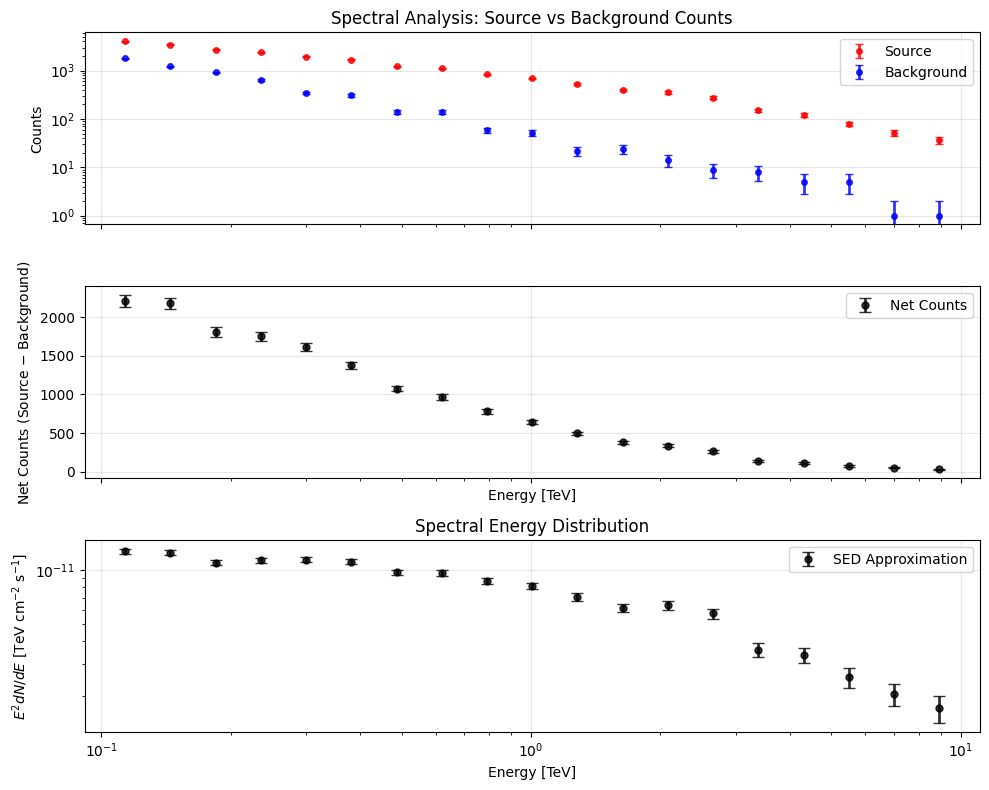

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Displaying source & background counts
ax1.errorbar(
    bin_centers,
    src_counts,
    yerr=src_errors,
    fmt="o",
    color="red",
    markersize=4,
    linewidth=2,
    label="Source",
    capsize=3,
    alpha=0.8,
)
ax1.errorbar(
    bin_centers,
    bkg_counts,
    yerr=bkg_errors,
    fmt="o",
    color="blue",
    markersize=4,
    linewidth=2,
    label="Background",
    capsize=3,
    alpha=0.8,
)
ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_ylabel("Counts")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Spectral Analysis: Source vs Background Counts")

# Displaying (source - background) counts
ax2.errorbar(
    bin_centers,
    net_counts,
    yerr=net_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="Net Counts",
    capsize=4,
    alpha=0.8,
)
ax2.set_xscale("log")
ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel("Net Counts (Source $-$ Background)")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Displaying SED
ax3.errorbar(
    bin_centers,
    sed_points,
    yerr=sed_errors,
    fmt="o",
    color="black",
    markersize=5,
    linewidth=2,
    label="SED Approximation",
    capsize=4,
    alpha=0.8,
)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy [TeV]")
ax3.set_ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_title("Spectral Energy Distribution")

plt.tight_layout()
plt.show()

**Angular SED**

In [83]:
ANGLE_BINS = np.linspace(0.0, 0.13, 20)
ENERGY_RANGES = [(0.5, 1.5), (1.5, 4.0), (4.0, 10.0)]

angle_bin_centers = (ANGLE_BINS[1:] + ANGLE_BINS[:-1]) / 2
exposure_time = np.sum(data["t_tot"])
blazar_offset = np.mean(data["offsets"])


def calculate_angular_sed_for_range(E_min, E_max, data_percentage=1.0):
    dE = E_max - E_min
    E_mean = (E_max + E_min) / 2

    energy_mask = (data["all_energies"] > E_min) & (data["all_energies"] < E_max)

    # This is if wanting to sample only part of the data.
    data_len = len(data["all_energies"])
    if data_percentage == 1.0:
        data_cut_mask = np.ones(data_len, dtype=bool)
    else:
        data_cut_mask = np.zeros(data_len, dtype=bool)
        n_true = int(data_len * data_percentage)
        data_cut_mask[:n_true] = True

    counts_per_bin = []

    for i in range(len(ANGLE_BINS) - 1):
        angle_mask = (data["all_sep"] ** 2 >= ANGLE_BINS[i]) & (
            data["all_sep"] ** 2 < ANGLE_BINS[i + 1]
        )
        counts = np.sum(angle_mask & energy_mask & data_cut_mask)
        counts_per_bin.append(counts)

    counts_per_bin = np.array(counts_per_bin)

    # TODO: use a better effective area, dont use center of angle**2 bin.
    effective_areas = np.array(
        [
            aeff.evaluate(energy_true=E_mean * u.TeV, offset=np.sqrt(angle_sq) * u.deg)
            .to(u.cm**2)
            .value
            for angle_sq in angle_bin_centers
        ]
    )

    sed_values = (
        counts_per_bin
        * (E_mean**2)
        / ((exposure_time * data_percentage) * effective_areas * dE)
    )
    sed_errors = sed_values / np.sqrt(np.maximum(counts_per_bin, 1))

    return sed_values, sed_errors

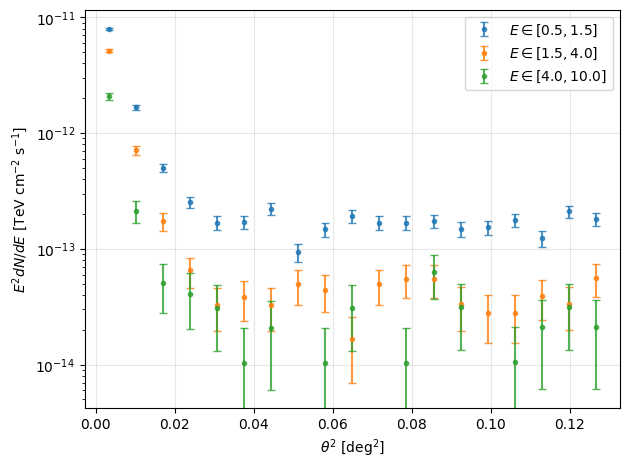

In [85]:
for E_min, E_max in ENERGY_RANGES:
    sed_values, sed_errors = calculate_angular_sed_for_range(
        E_min, E_max, data_percentage=1.0
    )

    plt.errorbar(
        angle_bin_centers,
        sed_values,
        yerr=sed_errors,
        fmt=".",
        markersize=6,
        linewidth=1.5,
        capsize=3,
        alpha=0.8,
        label=rf"$E\in[{E_min}, {E_max}]$",
    )

plt.yscale("log")
plt.xlabel(r"$\theta^2$ [deg$^2$]")
plt.ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
# plt.title("Angular SED")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Comparing with Korochkin paper data**

Here the data is extrapolated from "Korochkin_2021, Sensitivity Reach of Gamma-Ray Measurements for Strong Cosmological Magnetic Field" using plot digitizer.

In [86]:
def extr_data_from_csv(filepath):
    tot_datapoints = 19
    data = np.genfromtxt(filepath, delimiter=",", skip_header=1)

    if data.size == 0:
        return np.zeros(tot_datapoints)

    if data.ndim == 1:
        values = data
    else:
        values = data[:, 1] if data.shape[1] > 1 else data[:, 0]

    if len(values) < tot_datapoints:
        values = np.append(values, np.zeros(tot_datapoints - len(values)))

    return values


paper_src_0d5_1d5 = extr_data_from_csv("../data/corchkin_0d5_1d5TeV_blk_line.csv")
paper_src_1d5_4 = extr_data_from_csv("../data/corchkin_1d5_4TeV_blk_line.csv")
paper_src_4_10 = extr_data_from_csv("../data/corchkin_4_10TeV_blk_line.csv")

paper_red_0d5_1d5 = extr_data_from_csv("../data/corchkin_0d5_1d5TeV_red_line.csv")
paper_green_0d5_1d5 = extr_data_from_csv("../data/corchkin_0d5_1d5TeV_gre_line.csv")
paper_blue_0d5_1d5 = extr_data_from_csv("../data/corchkin_0d5_1d5TeV_blu_line.csv")

paper_red_1d5_4 = extr_data_from_csv("../data/corchkin_1d5_4TeV_red_line.csv")
paper_green_1d5_4 = extr_data_from_csv("../data/corchkin_1d5_4TeV_gre_line.csv")
paper_blue_1d5_4 = extr_data_from_csv("../data/corchkin_1d5_4TeV_blu_line.csv")

paper_red_4_10 = extr_data_from_csv("../data/corchkin_4_10TeV_red_line.csv")
paper_green_4_10 = extr_data_from_csv("../data/corchkin_4_10TeV_gre_line.csv")
paper_blue_4_10 = extr_data_from_csv("../data/corchkin_4_10TeV_blu_line.csv")

paper_bkg_0d5_1d5 = 4e-14
paper_bkg_1d5_4 = 7.5e-15
paper_bkg_4_10 = 1.5e-15

paper_data = {
    "0.5-1.5 TeV": (
        paper_src_0d5_1d5,
        paper_red_0d5_1d5,
        paper_blue_0d5_1d5,
        paper_green_0d5_1d5,
        paper_bkg_0d5_1d5,
    ),
    "1.5-4 TeV": (
        paper_src_1d5_4,
        paper_red_1d5_4,
        paper_blue_1d5_4,
        paper_green_1d5_4,
        paper_bkg_1d5_4,
    ),
    "4-10 TeV": (
        paper_src_4_10,
        paper_red_4_10,
        paper_blue_4_10,
        paper_green_4_10,
        paper_bkg_4_10,
    ),
}

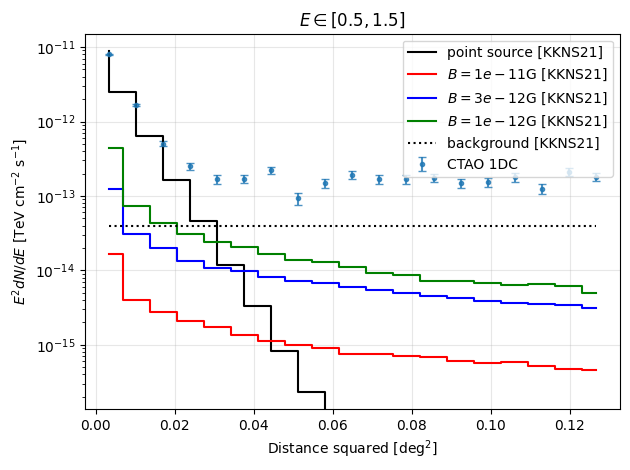

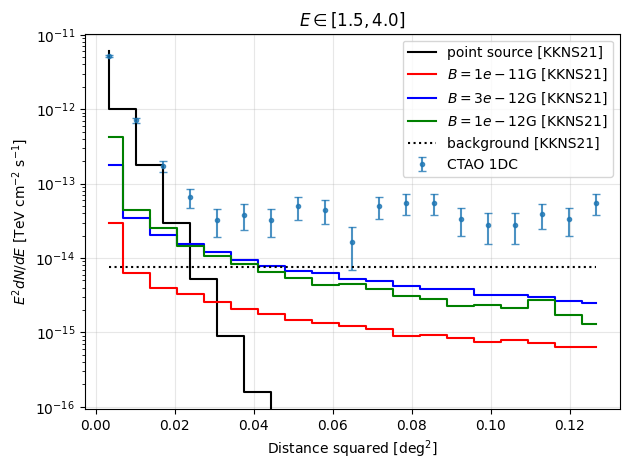

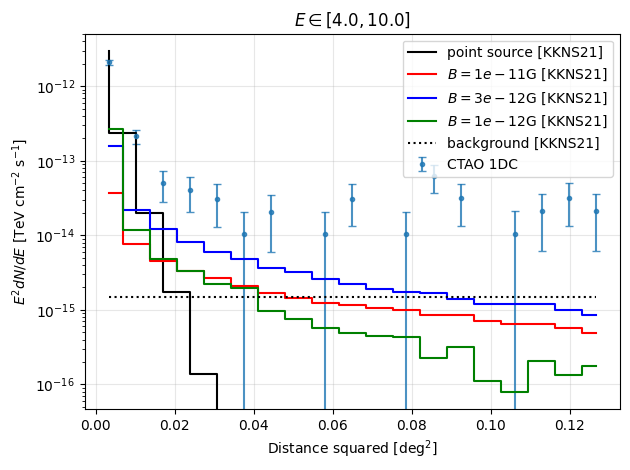

In [87]:
for dataset_name, dataset_data in paper_data.items():

    E_min, E_max = map(float, dataset_name.split(" ")[0].split("-"))
    sed_values, sed_errors = calculate_angular_sed_for_range(E_min, E_max)

    plt.errorbar(
        angle_bin_centers,
        sed_values,
        yerr=sed_errors,
        fmt=".",
        markersize=6,
        linewidth=1.5,
        capsize=3,
        alpha=0.8,
        label="CTAO 1DC",
    )
    plt.step(angle_bin_centers, dataset_data[0], "k", label="point source [KKNS21]")

    plt.step(
        angle_bin_centers,
        dataset_data[1],
        "r",
        label=rf"$B=1e-11$G [KKNS21]",
        where="mid",
    )
    plt.step(
        angle_bin_centers,
        dataset_data[2],
        "b",
        label=rf"$B=3e-12$G [KKNS21]",
        where="mid",
    )
    plt.step(
        angle_bin_centers,
        dataset_data[3],
        "g",
        label=rf"$B=1e-12$G [KKNS21]",
        where="mid",
    )
    plt.plot(
        angle_bin_centers,
        dataset_data[4] * angle_bin_centers**0,
        "k:",
        label="background [KKNS21]",
    )

    plt.yscale("log")
    plt.xlabel(r"Distance squared [deg$^2$]")
    plt.ylabel(r"$E^2 dN/dE$ [TeV cm$^{-2}$ s$^{-1}$]")
    plt.title(rf"$E\in[{E_min}, {E_max}]$")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

**Fitting CTAO 1DC data with a sum of the components from the paper with different normalizations**

In [154]:
def gauss_src(sigma):
    return np.exp(-angle_bin_centers / (2 * sigma**2))


def fit_model(ext_data, angle_centers, bkg, src_norm, src_sigma, bkg_norm):
    src = src_norm * gauss_src(src_sigma)
    bkg = bkg_norm * bkg
    return src + bkg


def fit_model_ext(
    ext_data, angle_centers, bkg, src_norm, src_sigma, bkg_norm, ext_norm
):
    src = src_norm * gauss_src(src_sigma)
    bkg_ = bkg_norm * bkg
    ext = ext_norm * ext_data
    return src + bkg_ + ext


def fit_model_ext_double(
    ext_data1,
    ext_data2,
    angle_centers,
    bkg1,
    bkg2,
    src_norm1,
    src_norm2,
    src_sigma1,
    src_sigma2,
    bkg_norm1,
    bkg_norm2,
    ext_norm,
):
    src1 = src_norm1 * gauss_src(src_sigma1)
    bkg1_ = bkg_norm1 * bkg1
    ext1 = ext_norm * ext_data1
    model1 = src1 + bkg1_ + ext1

    src2 = src_norm2 * gauss_src(src_sigma2)
    bkg2_ = bkg_norm2 * bkg2
    ext2 = ext_norm * ext_data2
    model2 = src2 + bkg2_ + ext2

    return np.concatenate([model1, model2])

In [155]:
from scipy.optimize import curve_fit

for dataset_name, dataset_data in paper_data.items():
    if dataset_name == "4-10 TeV":
        continue  # There is not enough CTAO data for this.

    ext_data = dataset_data[3]  # green
    bkg = dataset_data[4]

    E_min, E_max = map(float, dataset_name.split(" ")[0].split("-"))
    sed_values, sed_errors = calculate_angular_sed_for_range(E_min, E_max)

    init_guess = [1.0, 0.1, 1.0]

    def fit_function(angle_centers, src_norm, src_sigma, bkg_norm):
        return fit_model(ext_data, angle_centers, bkg, src_norm, src_sigma, bkg_norm)

    popt, pcov = curve_fit(
        fit_function,
        angle_bin_centers,
        sed_values,
        sigma=sed_errors,
        p0=init_guess,
        absolute_sigma=True,
    )
    src_norm_fit, src_sigma_fit, bkg_norm_fit = popt
    src_norm_err, src_sigma_err, bkg_norm_err = np.sqrt(np.diag(pcov))
    fit = fit_function(angle_bin_centers, *popt)

    print(f"{dataset_name}:")
    print(rf"Background normalization: {bkg_norm_fit:.3f} $\pm$ {bkg_norm_err:.3f}")
    print(rf"Source normalization: {src_norm_fit} $\pm$ {src_norm_err}")
    print(rf"Src sigma: {src_sigma_fit:.3f} $\pm$ {src_sigma_err:.3f}")
    print("\n")

0.5-1.5 TeV:
Background normalization: 4.011 $\pm$ 0.144
Source normalization: 4.57968207446482e-11 $\pm$ 7.848063710986361e-13
Src sigma: 0.049 $\pm$ 0.000


1.5-4 TeV:
Background normalization: 4.531 $\pm$ 0.465
Source normalization: 1.442155933792926e-11 $\pm$ 7.96581064017888e-13
Src sigma: 0.043 $\pm$ 0.001




3σ threshold ($B=10^{-12}$G): ext_norm = 5.000
3σ threshold ($B=3\cdot10^{-12}$G): ext_norm = 1.515
3σ threshold ($B=10^{-11}$G): ext_norm = 0.960


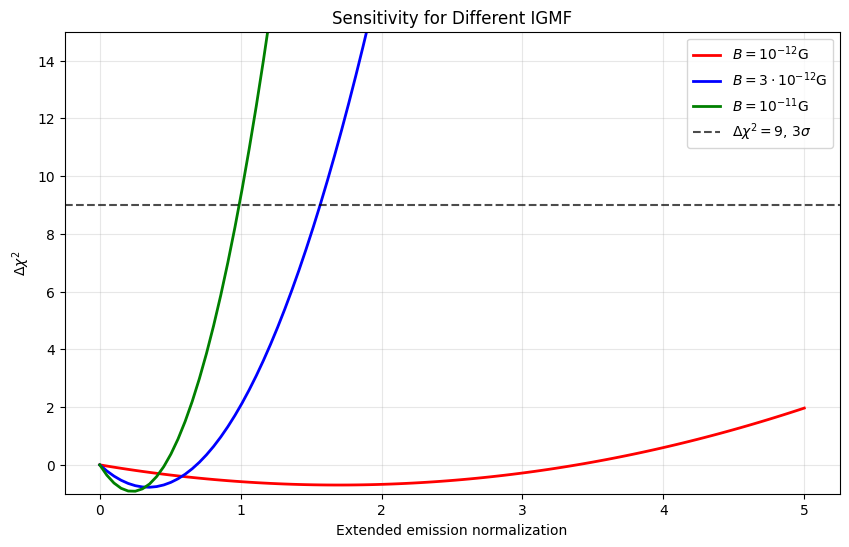

In [156]:
ext_norms = np.linspace(0.0, 5.0, 100)

ext_data_B1 = paper_data["0.5-1.5 TeV"][1]
ext_data_B2 = paper_data["0.5-1.5 TeV"][2]
ext_data_B3 = paper_data["0.5-1.5 TeV"][3]

ext_data2_B1 = paper_data["1.5-4 TeV"][1]
ext_data2_B2 = paper_data["1.5-4 TeV"][2]
ext_data2_B3 = paper_data["1.5-4 TeV"][3]

bkg1 = paper_data["0.5-1.5 TeV"][4]
bkg2 = paper_data["1.5-4 TeV"][4]

sed_values1, sed_errors1 = calculate_angular_sed_for_range(0.5, 1.5)
sed_values2, sed_errors2 = calculate_angular_sed_for_range(1.5, 4)

sed_values_double = np.concatenate([sed_values1, sed_values2])
sed_errors_double = np.concatenate([sed_errors1, sed_errors2])


def null_model_double(
    angle_centers, src_norm1, src_norm2, src_sigma1, src_sigma2, bkg_norm1, bkg_norm2
):
    dummy_ext = np.zeros_like(ext_data_B1)
    return fit_model_ext_double(
        dummy_ext,
        dummy_ext,
        angle_centers,
        bkg1,
        bkg2,
        src_norm1,
        src_norm2,
        src_sigma1,
        src_sigma2,
        bkg_norm1,
        bkg_norm2,
        0.0,
    )


init_guess = [15.0, 10.0, 0.15, 0.15, 1.0, 1.0]

popt_null, _ = curve_fit(
    null_model_double,
    angle_bin_centers,
    sed_values_double,
    sigma=sed_errors_double,
    p0=init_guess,
    absolute_sigma=True,
    maxfev=5000,
)

chi2_null = np.sum(
    (
        (sed_values_double - null_model_double(angle_bin_centers, *popt_null))
        / sed_errors_double
    )
    ** 2
)

results = {}
B_fields = [r"$B=10^{-12}$G", r"$B=3\cdot10^{-12}$G", "$B=10^{-11}$G"]

for B_name, (ext1, ext2) in zip(
    B_fields,
    [
        (ext_data_B1, ext_data2_B1),
        (ext_data_B2, ext_data2_B2),
        (ext_data_B3, ext_data2_B3),
    ],
):

    chi2s = []

    for ext_norm in ext_norms:
        model = fit_model_ext_double_two_sigma(
            ext1,
            ext2,
            angle_bin_centers,
            bkg1,
            bkg2,
            popt_null[0],
            popt_null[1],
            popt_null[2],
            popt_null[3],
            popt_null[4],
            popt_null[5],
            ext_norm,
        )

        chi2 = np.sum(((sed_values_double - model) / sed_errors_double) ** 2)
        chi2s.append(chi2)

    delta_chi2s = np.array(chi2s) - chi2_null
    results[B_name] = delta_chi2s

    mask = delta_chi2s < 9
    if np.any(mask):
        threshold_idx = np.where(mask)[0][-1]
        threshold_norm = ext_norms[threshold_idx]
        print(f"3σ threshold ({B_name}): ext_norm = {threshold_norm:.3f}")
    else:
        print(f"No 3σ threshold for {B_name}")

plt.figure(figsize=(10, 6))

colors = ["red", "blue", "green"]
for (B_name, delta_chi2s), color in zip(results.items(), colors):
    plt.plot(ext_norms, delta_chi2s, label=f"{B_name}", color=color, linewidth=2)

plt.axhline(
    9,
    color="black",
    linestyle="--",
    linewidth=1.5,
    alpha=0.7,
    label=r"$\Delta\chi^2=9$, $3\sigma$",
)

plt.legend()
plt.ylim([-1, 15])
plt.ylabel(r"$\Delta\chi^2$")
plt.xlabel("Extended emission normalization")
plt.title("Sensitivity for Different IGMF")
plt.grid(True, alpha=0.3)
plt.show()